# SNN MNIST Classifier 📊

이 노트북에서는 snnTorch를 사용하여 MNIST 손글씨 숫자 인식을 위한 Spiking Neural Network (SNN)를 구현합니다.

## 개요
- 정적 이미지(MNIST)를 스파이크 시퀀스로 변환
- LIF 뉴런을 사용한 SNN 모델 구축
- 스파이크 활동 시각화
- M1 Mac MPS 가속 활용

## 1. 라이브러리 임포트 및 설정

In [1]:
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
from snntorch import functional as SF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 디바이스 설정 (M1 Mac MPS 활용)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 시각화 설정
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Matplotlib is building the font cache; this may take a moment.


Using device: mps


## 2. 하이퍼파라미터 설정

In [2]:
# 하이퍼파라미터
batch_size = 128
data_path = './data'
num_steps = 25    # 스파이크 시퀀스 길이 (시간 스텝 수)
beta = 0.95       # LIF 뉴런의 멤브레인 전압 감쇠율 (decay rate)
num_epochs = 10
learning_rate = 5e-4

# 네트워크 구조
num_inputs = 28*28
num_hidden = 100  # 은닉층 뉴런 수
num_outputs = 10  # MNIST 클래스 수

print(f"Configuration:")
print(f"- Batch size: {batch_size}")
print(f"- Time steps: {num_steps}")
print(f"- Beta (decay): {beta}")
print(f"- Hidden neurons: {num_hidden}")
print(f"- Learning rate: {learning_rate}")

Configuration:
- Batch size: 128
- Time steps: 25
- Beta (decay): 0.95
- Hidden neurons: 100
- Learning rate: 0.0005


## 3. MNIST 데이터 로드 및 전처리

In [3]:
# 데이터 변환: 텐서화, 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# MNIST 데이터셋 다운로드 및 로드
mnist_train = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}")
print(f"Number of batches: {len(train_loader)}")

100.0%
100.0%
100.0%
100.0%

Train dataset size: 60000
Test dataset size: 10000
Number of batches: 469


## 4. 데이터 시각화

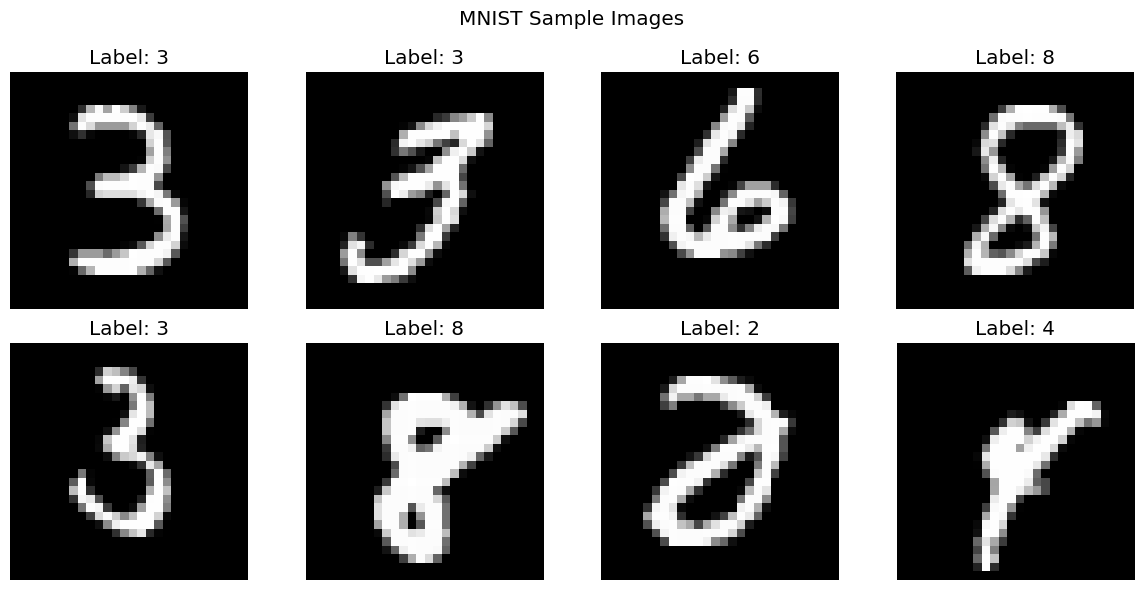

In [4]:
# 원본 MNIST 이미지 시각화
def visualize_mnist_samples(loader, num_samples=8):
    """MNIST 샘플 이미지들을 시각화합니다."""
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.suptitle('MNIST Sample Images')
    plt.tight_layout()
    plt.show()

visualize_mnist_samples(train_loader)

## 5. 스파이크 인코딩 및 시각화

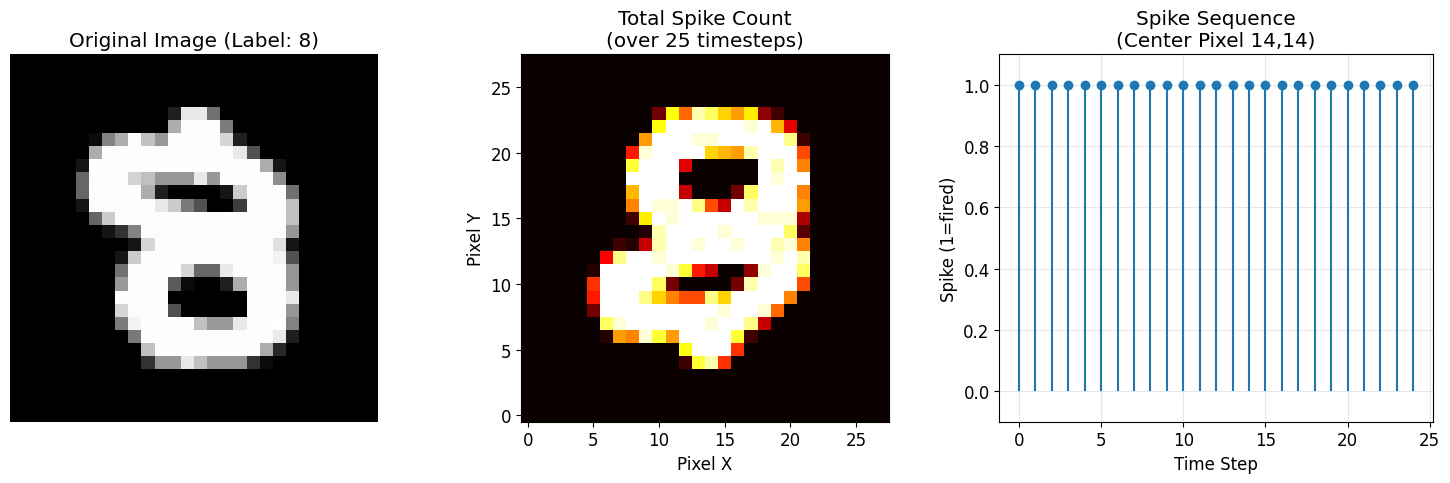

In [7]:
def visualize_spike_encoding(image, label, num_steps=25):
    """이미지의 스파이크 인코딩을 시각화합니다."""
    # Rate coding을 사용하여 스파이크 시퀀스 생성
    # 픽셀 값에 비례하여 스파이크 발생 확률 결정
    spike_data = snn.spikegen.rate(image.squeeze(), num_steps=num_steps, gain=1, offset=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 원본 이미지
    axes[0].imshow(image.squeeze().numpy(), cmap='gray')
    axes[0].set_title(f'Original Image (Label: {label})')
    axes[0].axis('off')
    
    # 총 스파이크 수 (시간 축으로 합산)
    total_spikes = spike_data.sum(dim=0).numpy()
    axes[1].imshow(total_spikes, cmap='hot', origin='lower')
    axes[1].set_title(f'Total Spike Count\n(over {num_steps} timesteps)')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # 특정 픽셀의 스파이크 시퀀스 (중앙 픽셀)
    center_pixel_spikes = spike_data[:, 14, 14].numpy()
    time_steps = np.arange(num_steps)
    axes[2].stem(time_steps, center_pixel_spikes, basefmt=" ")
    axes[2].set_title('Spike Sequence\n(Center Pixel 14,14)')
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Spike (1=fired)')
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return spike_data

# 첫 번째 이미지로 스파이크 인코딩 시연
sample_images, sample_labels = next(iter(train_loader))
spike_example = visualize_spike_encoding(sample_images[0], sample_labels[0].item(), num_steps)

## 6. SNN 모델 정의

In [8]:
class SNNNet(nn.Module):
    """간단한 2층 SNN 모델"""
    
    def __init__(self, num_inputs, num_hidden, num_outputs, beta):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.beta = beta

        # 레이어 정의
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        """순전파 함수
        
        Args:
            x: 입력 스파이크 시퀀스 (num_steps, batch_size, num_inputs)
            
        Returns:
            cur_out: 출력층의 멤브레인 전압 시퀀스
            spk_out: 출력층의 스파이크 시퀀스
            spk_hidden: 은닉층의 스파이크 시퀀스 (시각화용)
        """
        # 멤브레인 전압 초기화
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur_list = []  # 출력층 전류 기록
        spk_list = []  # 출력층 스파이크 기록
        spk_hidden_list = []  # 은닉층 스파이크 기록

        # 시간 스텝별 순전파
        for step in range(x.size(0)):  # num_steps
            cur1 = self.fc1(x[step].view(-1, self.num_inputs))  # Flatten 후 FC1
            spk1, mem1 = self.lif1(cur1, mem1)  # LIF 뉴런 1
            cur2 = self.fc2(spk1)  # FC2
            spk2, mem2 = self.lif2(cur2, mem2)  # LIF 뉴런 2

            cur_list.append(cur2)
            spk_list.append(spk2)
            spk_hidden_list.append(spk1)

        return torch.stack(cur_list, dim=0), torch.stack(spk_list, dim=0), torch.stack(spk_hidden_list, dim=0)

# 모델 인스턴스 생성
net = SNNNet(num_inputs, num_hidden, num_outputs, beta).to(device)
print(f"Model created with {sum(p.numel() for p in net.parameters())} parameters")
print(net)

Model created with 79510 parameters
SNNNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (lif2): Leaky()
)


## 7. 학습 설정

In [9]:
# 옵티마이저 및 손실 함수
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()

# 학습 기록용 변수
loss_hist = []
test_acc_hist = []
train_acc_hist = []

## 8. 평가 함수 정의

In [10]:
def evaluate_model(net, data_loader, device, num_steps):
    """모델 성능 평가 함수"""
    net.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            # 스파이크 시퀀스 생성 (간단한 반복 방식)
            spike_data = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1).to(device)
            labels = labels.to(device)
            
            # 순전파
            cur_out, spk_out, _ = net(spike_data)
            
            # 예측 (총 스파이크 수 기반)
            total_spikes = spk_out.sum(dim=0)  # 시간 축으로 합산
            _, predicted = total_spikes.max(1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def print_batch_accuracy(net, images, labels, device, num_steps, train=False):
    """배치 정확도 출력 함수"""
    accuracy = evaluate_single_batch(net, images, labels, device, num_steps)
    if train:
        print(f"  Batch Accuracy: {accuracy * 100:.2f}%")
    return accuracy

def evaluate_single_batch(net, images, labels, device, num_steps):
    """단일 배치 평가"""
    net.eval()
    with torch.no_grad():
        spike_data = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1).to(device)
        labels = labels.to(device)
        
        cur_out, spk_out, _ = net(spike_data)
        total_spikes = spk_out.sum(dim=0)
        _, predicted = total_spikes.max(1)
        
        accuracy = (predicted == labels).sum().item() / labels.size(0)
    net.train()
    return accuracy

## 9. 학습 루프

In [12]:
print("Starting training...")
print(f"Device: {device}")
print("-" * 50)

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    num_correct = 0
    num_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # 스파이크 시퀀스 생성 (간단한 반복 방식)
        # 실제로는 snn.spikegen.rate()를 사용할 수 있음
        spike_data = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1).to(device)
        labels = labels.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순전파
        cur_out, spk_out, spk_hidden = net(spike_data)

        # 손실 계산 (총 스파이크 수 기반)
        loss = loss_fn(spk_out.sum(dim=0), labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        epoch_loss += loss.item()
        loss_hist.append(loss.item())
        
        # 정확도 계산
        with torch.no_grad():
            total_spikes = spk_out.sum(dim=0)
            _, predicted = total_spikes.max(1)
            num_correct += (predicted == labels).sum().item()
            num_samples += labels.size(0)

        # 진행 상황 출력
        if (i + 1) % 100 == 0:
            batch_acc = (predicted == labels).sum().item() / labels.size(0)
            print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}")
            print(f"  Loss: {loss.item():.4f}, Batch Acc: {batch_acc*100:.2f}%")

    # 에포크 종료 시 평가
    train_accuracy = num_correct / num_samples
    test_accuracy = evaluate_model(net, test_loader, device, num_steps)
    
    train_acc_hist.append(train_accuracy)
    test_acc_hist.append(test_accuracy)
    
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Average Loss: {epoch_loss/len(train_loader):.4f}")
    print(f"  Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
    print("-" * 50)

print("Training completed!")

Starting training...
Device: mps
--------------------------------------------------
Epoch 1/10, Step 100/469
  Loss: 0.0054, Batch Acc: 100.00%
Epoch 1/10, Step 200/469
  Loss: 0.0484, Batch Acc: 99.22%
Epoch 1/10, Step 300/469
  Loss: 0.0220, Batch Acc: 99.22%
Epoch 1/10, Step 400/469
  Loss: 0.0375, Batch Acc: 99.22%

Epoch 1 Results:
  Average Loss: 0.0240
  Train Accuracy: 99.24%
  Test Accuracy: 97.55%
--------------------------------------------------
Epoch 2/10, Step 100/469
  Loss: 0.0113, Batch Acc: 99.22%


KeyboardInterrupt: 

## 10. 학습 결과 시각화

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

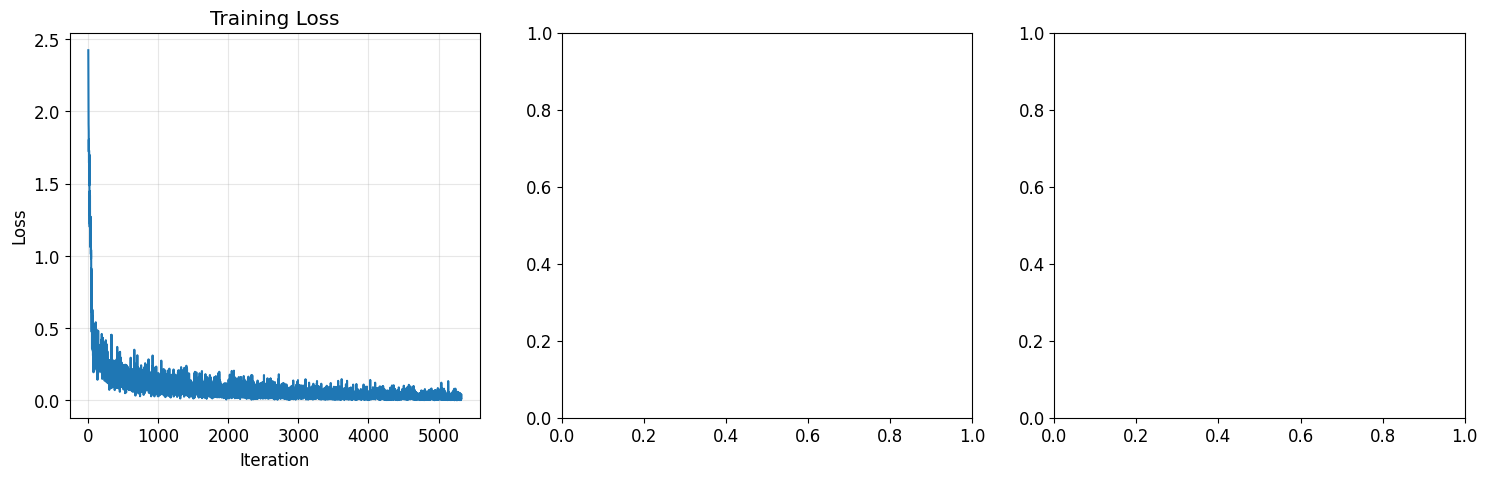

In [13]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 손실 그래프
axes[0].plot(loss_hist)
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)

# 정확도 그래프
epochs_range = range(1, num_epochs + 1)
axes[1].plot(epochs_range, [acc*100 for acc in train_acc_hist], 'b-', label='Train Accuracy')
axes[1].plot(epochs_range, [acc*100 for acc in test_acc_hist], 'r-', label='Test Accuracy')
axes[1].set_title("Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 최종 성능 표시
final_train_acc = train_acc_hist[-1] * 100
final_test_acc = test_acc_hist[-1] * 100
axes[2].bar(['Train', 'Test'], [final_train_acc, final_test_acc], 
           color=['blue', 'red'], alpha=0.7)
axes[2].set_title("Final Accuracy")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_ylim(0, 100)

# 값 표시
axes[2].text(0, final_train_acc + 1, f'{final_train_acc:.1f}%', 
            ha='center', va='bottom', fontweight='bold')
axes[2].text(1, final_test_acc + 1, f'{final_test_acc:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Train Accuracy: {final_train_acc:.2f}%")
print(f"Test Accuracy: {final_test_acc:.2f}%")

## 11. 스파이크 활동 시각화

Visualizing spike activity for test samples...

Sample 1:


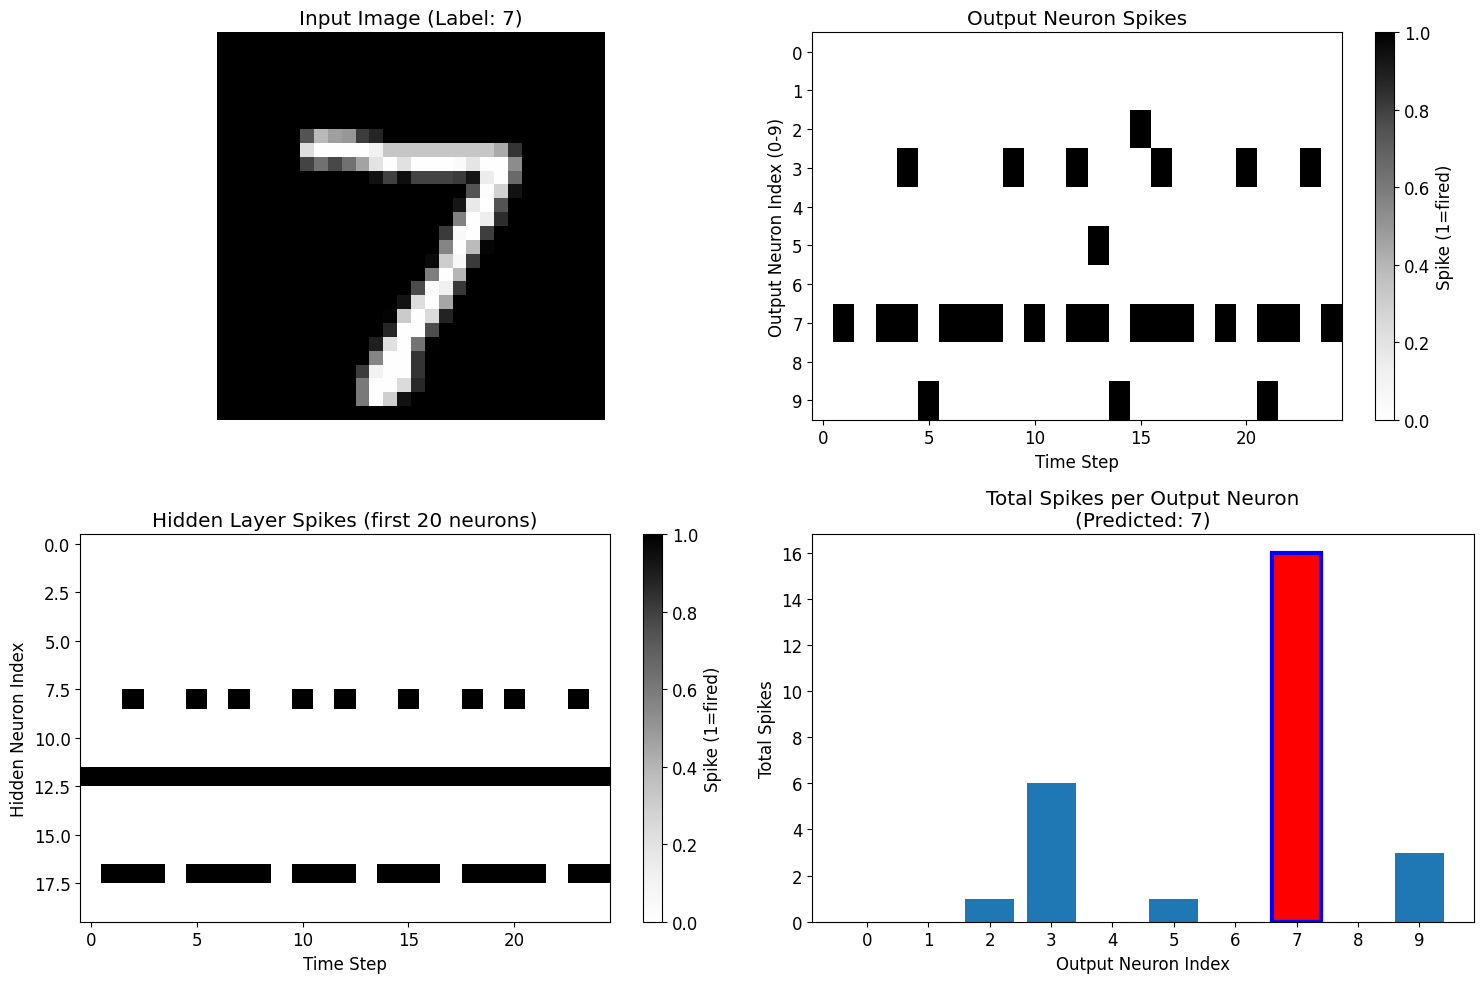

Prediction correct!

Sample 2:


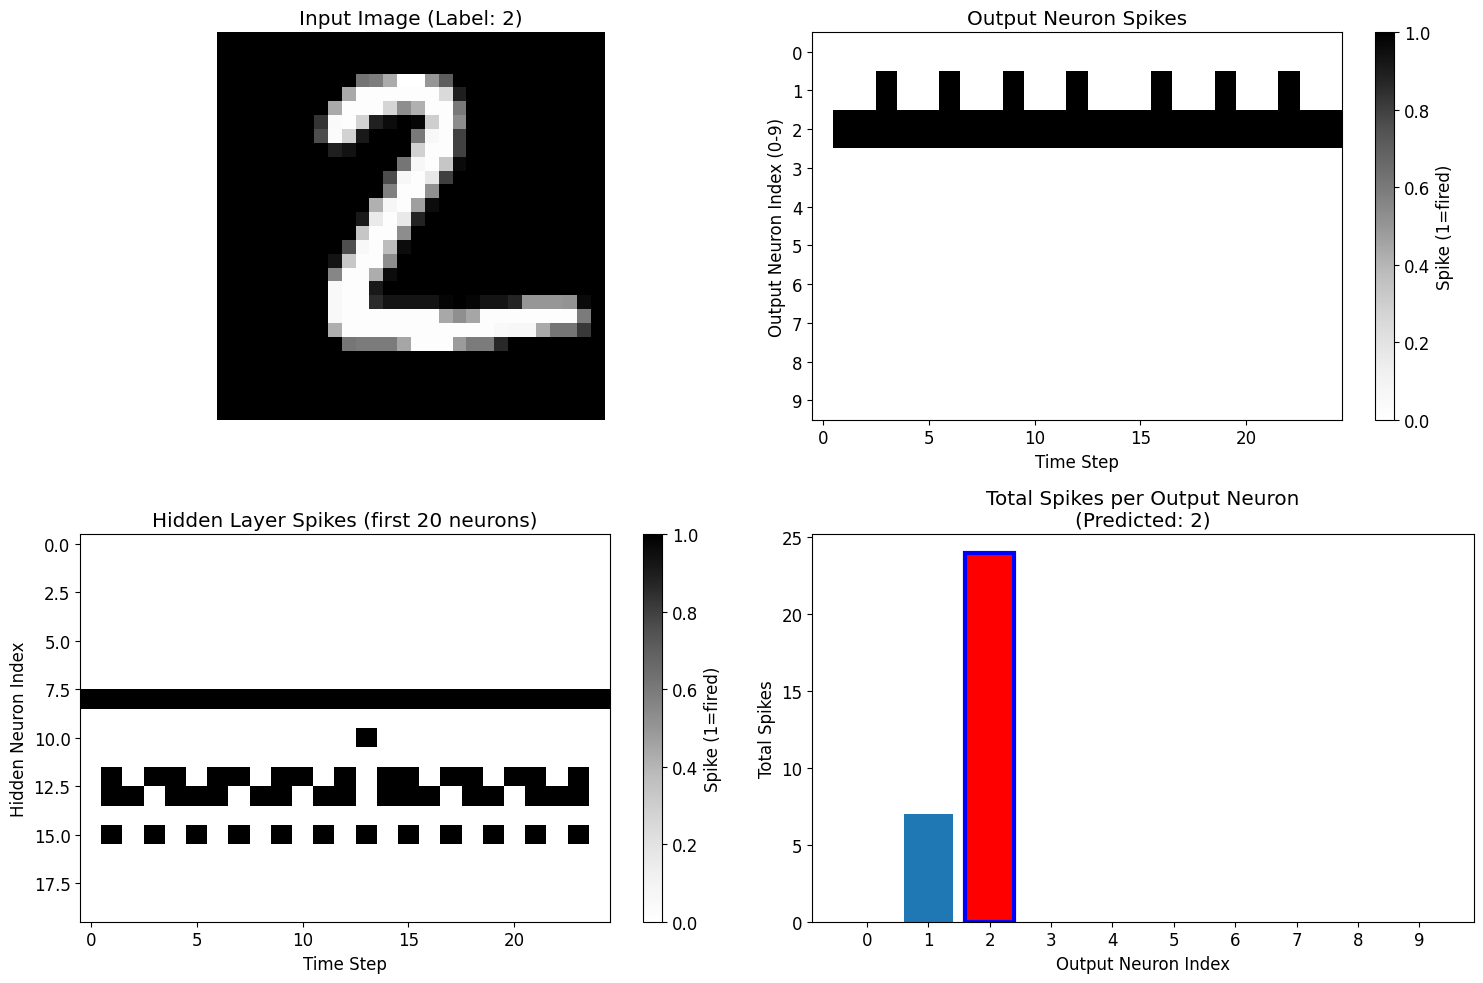

Prediction correct!

Sample 3:


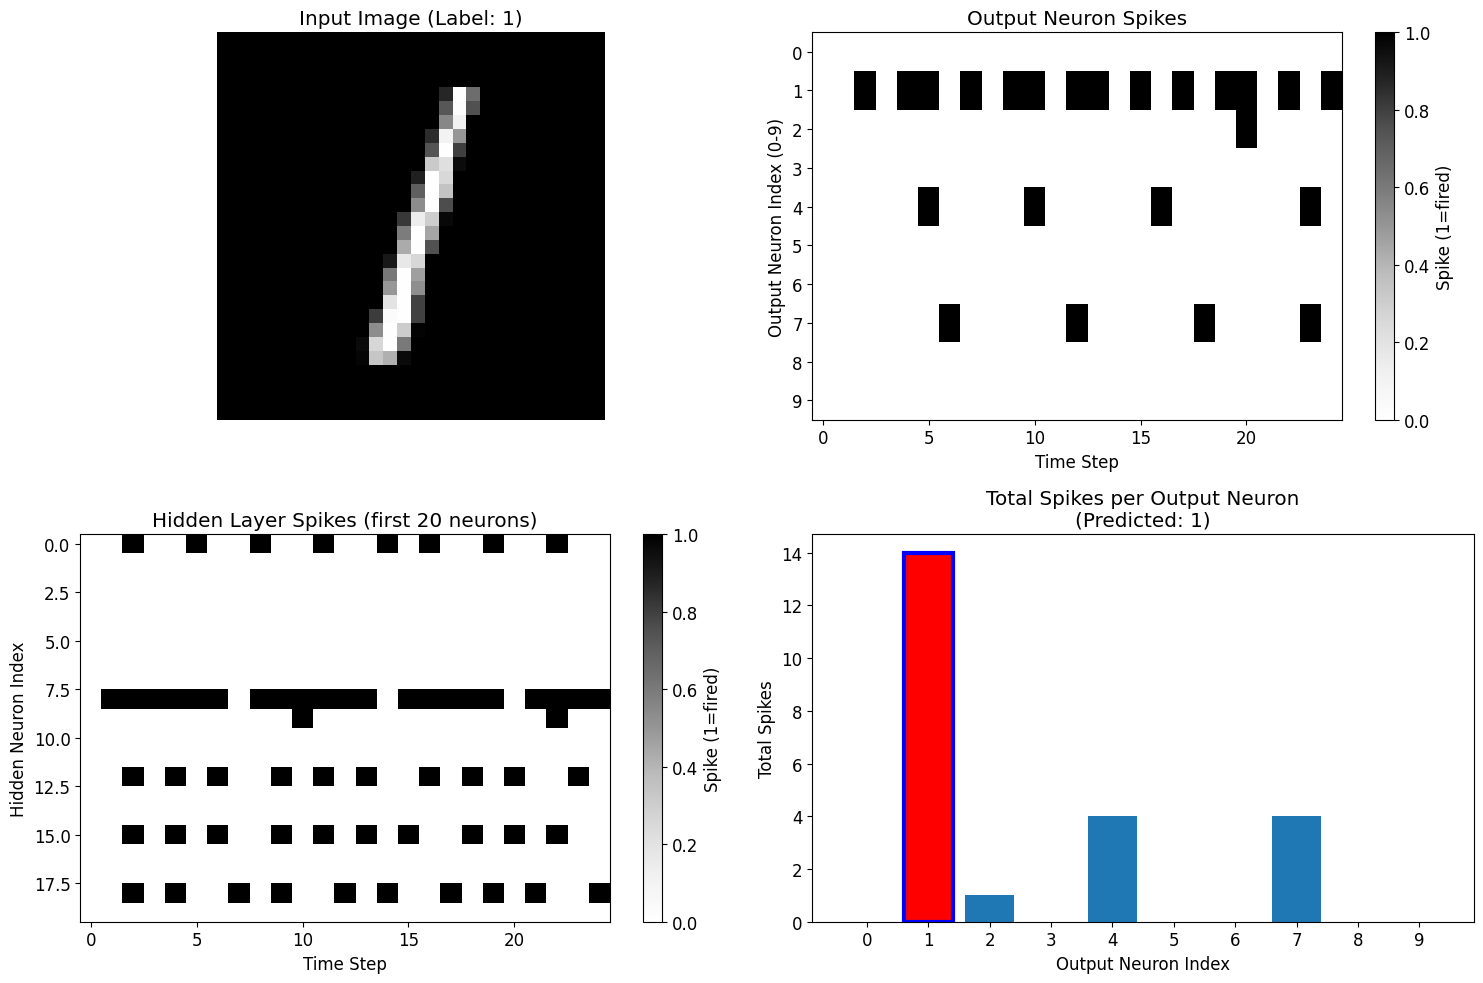

Prediction correct!


In [15]:
def visualize_spike_activity(net, images, labels, device, num_steps, sample_idx=0):
    """특정 샘플에 대한 스파이크 활동 시각화"""
    net.eval()
    
    # 단일 샘플 선택
    sample_image = images[sample_idx:sample_idx+1]
    sample_label = labels[sample_idx:sample_idx+1]
    
    # 스파이크 시퀀스 생성
    spike_data = sample_image.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1).to(device)
    sample_label = sample_label.to(device)
    
    with torch.no_grad():
        cur_out, spk_out, spk_hidden = net(spike_data)
    
    # CPU로 이동
    spk_out_cpu = spk_out.cpu().numpy()  # (num_steps, batch_size, num_outputs)
    spk_hidden_cpu = spk_hidden.cpu().numpy()  # (num_steps, batch_size, num_hidden)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 원본 이미지
    axes[0,0].imshow(sample_image.squeeze().numpy(), cmap='gray')
    axes[0,0].set_title(f'Input Image (Label: {sample_label.item()})')
    axes[0,0].axis('off')
    
    # 출력 뉴런 스파이크 활동
    output_spikes = spk_out_cpu[:, 0, :].T  # (num_outputs, num_steps)
    im1 = axes[0,1].imshow(output_spikes, cmap='Greys', aspect='auto')
    axes[0,1].set_title('Output Neuron Spikes')
    axes[0,1].set_xlabel('Time Step')
    axes[0,1].set_ylabel('Output Neuron Index (0-9)')
    axes[0,1].set_yticks(range(10))
    plt.colorbar(im1, ax=axes[0,1], label='Spike (1=fired)')
    
    # 은닉층 뉴런 스파이크 활동 (처음 20개만)
    hidden_spikes = spk_hidden_cpu[:, 0, :20].T  # (20, num_steps)
    im2 = axes[1,0].imshow(hidden_spikes, cmap='Greys', aspect='auto')
    axes[1,0].set_title('Hidden Layer Spikes (first 20 neurons)')
    axes[1,0].set_xlabel('Time Step')
    axes[1,0].set_ylabel('Hidden Neuron Index')
    plt.colorbar(im2, ax=axes[1,0], label='Spike (1=fired)')
    
    # 출력 뉴런별 총 스파이크 수
    total_spikes_per_neuron = output_spikes.sum(axis=1)
    predicted_label = np.argmax(total_spikes_per_neuron)
    
    bars = axes[1,1].bar(range(10), total_spikes_per_neuron)
    axes[1,1].set_title(f'Total Spikes per Output Neuron\n(Predicted: {predicted_label})')
    axes[1,1].set_xlabel('Output Neuron Index')
    axes[1,1].set_ylabel('Total Spikes')
    axes[1,1].set_xticks(range(10))
    
    # 예측된 클래스 강조
    bars[predicted_label].set_color('red')
    bars[sample_label.item()].set_edgecolor('blue')
    bars[sample_label.item()].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_label == sample_label.item()

# 테스트 샘플들에 대한 스파이크 활동 시각화
test_images, test_labels = next(iter(test_loader))

print("Visualizing spike activity for test samples...")
for i in range(min(3, len(test_images))):
    print(f"\nSample {i+1}:")
    is_correct = visualize_spike_activity(net, test_images, test_labels, device, num_steps, i)
    print(f"Prediction {'correct' if is_correct else 'incorrect'}!")

## 12. 모델 저장

In [16]:
# 모델 저장
model_path = 'snn_mnist_model.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
    'train_acc_hist': train_acc_hist,
    'test_acc_hist': test_acc_hist,
    'hyperparameters': {
        'num_inputs': num_inputs,
        'num_hidden': num_hidden,
        'num_outputs': num_outputs,
        'beta': beta,
        'num_steps': num_steps,
        'learning_rate': learning_rate
    }
}, model_path)

print(f"Model saved to {model_path}")
print(f"Final test accuracy: {test_acc_hist[-1]*100:.2f}%")

Model saved to snn_mnist_model.pth
Final test accuracy: 97.55%


## 결론

이 노트북에서는 snnTorch를 사용하여 MNIST 손글씨 숫자 인식을 위한 기본적인 SNN을 구현했습니다.

### 주요 학습 내용:
1. **스파이크 인코딩**: 정적 이미지를 스파이크 시퀀스로 변환
2. **LIF 뉴런**: Leaky Integrate-and-Fire 뉴런의 동작 원리
3. **시간 역학**: SNN에서 시간 차원의 중요성
4. **스파이크 기반 학습**: 대리 기울기를 통한 역전파
5. **시각화**: 스파이크 활동 패턴 분석

### 개선 방향:
- 더 정교한 스파이크 인코딩 기법 (Rate coding, Temporal coding)
- 다양한 뉴런 모델 (Synaptic, RSynaptic 등)
- CNN 구조와의 결합
- 실제 뉴로모픽 데이터셋 (N-MNIST, DVS 등) 활용